In [328]:
# changelog по сравнению с v0:
# добавил интерпретацию коэффициентов логистической регрессии
# поменял некоторые параметры в препроцессинге и моделях, улучшив целевую метрику
# добавил график, визуализирующий качество предсказаний рассматриваемых моделей

### Попробуем решить задачу бинарной классификации, определяя по погодным признакам одну из столиц - Москву или Санкт-Петербург.

Для всех моделей метрика - ROC-AUC.

Хорошо подходит для случаев, когда оба класса, во-первых, сбалансированы, во-вторых - одинаково важны.

А это как раз наш случай. 

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns

In [199]:
import warnings
warnings.simplefilter('ignore')

In [4]:
# техническое извлечение таблиц
df_spb = pd.read_csv('final_spb', sep=',')
df_moscow = pd.read_csv('final_moscow', sep=',')

In [5]:
# обработка значений для машинного обучения
df_spb.drop(columns='Дата', inplace=True) # конкретные даты нам уже не понадобятся
df_moscow.drop(columns='Дата', inplace=True)
df_spb['Город'] = np.zeros((len(df_spb.index), 1)) # добавляем категориальные признаки 
df_moscow['Город'] = np.ones((len(df_spb.index), 1))
df = pd.concat((df_spb, df_moscow), ignore_index=True) # объединяем в единый массив

In [113]:
# разбиваем признаки на числовые, категориальные и целевой 

nums = ['Ночная температура', 'Дневная температура', 'Влажность', 'Давление', 'Сила ветра', 'Перепад температур']
cats = ['Месяц', 'Направление ветра', 'Погодные явления']
targ = ['Город']

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report

In [114]:
# фиксируем random state и создаем тренировочные и тестовые выборки

RS = 2599

df_train, df_test = train_test_split(df, test_size=0.2, random_state=RS)

X_train = df_train.drop(columns='Город')
X_test = df_test.drop(columns='Город')

y_train = df_train['Город']
y_test = df_test['Город']

In [148]:
# обработка данных с one hot encoding и стандартизация числовых признаков одинакова для всех моделей 

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), nums),    
    ('ohe', OneHotEncoder(handle_unknown="error"), cats) # задаем drop=None, чтобы потом интерпретировать все признаки
])

## 1. Логистическая регрессия

Сначала ищем solver, потом оптимизируем доступные параметры. 

In [149]:
params = {'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

model_lr = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('logreg', LogisticRegression(random_state=RS, max_iter = 1000))
])

searcher_sol = GridSearchCV(
    model_lr, 
    params, cv=5, n_jobs=-1,
    scoring='roc_auc')

In [150]:
%%capture
searcher_sol.fit(X_train, y_train)

In [151]:
searcher_sol.best_params_
# оптимальный солвер найден 

{'logreg__solver': 'newton-cg'}

In [141]:
# теперь можем оптимизировать модель для получения итогового результата

In [152]:
alphas = np.logspace(-2, 4, 15) # значения для оптимизации скорости обучения 
params = {'logreg__penalty': ['l2'], 'logreg__C': alphas}

model_lr = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('logreg', LogisticRegression(random_state=RS, solver='newton-cg'))
])

searcher_lr = GridSearchCV(model_lr, params,
                        scoring="roc_auc", cv=5, n_jobs=-1)

In [153]:
%%capture
searcher_lr.fit(X_train, y_train)

In [154]:
y_pred_lr = searcher_lr.predict(X_test)
p_pred_lr = searcher_lr.predict_proba(X_test)
p_pred_lr = p_pred_lr[:, -1]

In [155]:
searcher_lr.best_params_

{'logreg__C': 1.3894954943731375, 'logreg__penalty': 'l2'}

In [156]:
print(classification_report(y_pred_lr, y_test))

              precision    recall  f1-score   support

         0.0       0.64      0.60      0.62       457
         1.0       0.57      0.62      0.59       393

    accuracy                           0.60       850
   macro avg       0.60      0.61      0.60       850
weighted avg       0.61      0.60      0.61       850



In [157]:
roc_auc_score(y_test, p_pred_lr)

0.6533902480885391

Итого: ROC-AUC почти достает до 0.7 - условной границы "хорошей" модели. Неплохо: СПб и Москва различаются достаточно сильно, чтобы отличать их друг от друга по данному датасету.

Точность и полнота печальные, но они и не являются ключевой метрикой. Интересно, что Санкт-Петербург определяется с чуть большей точностью, чем Москва. 

А еще мы можем вытащить коэффициенты из модели и их интерпретировать. \
Поиски решения этой не совсем тривиальной задачи привели к улучшению ROC-AUC и замене нескольких параметров в препроцессинге данных и в самой логистической регрессии. \
Главная трудность - достать признаки после препроцессинга OHE+scaling, усложняющаяся тем, что я использовал Pipeline; а также вытащить сами коэффициенты регрессии из того же Pipeline. 

https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer \
Из интересного: вопрос о том, что в каком порядке идут коэффициенты (сначала категориальные, а потом числовые, или наоборот). В комментах написали, что в том порядке, в котором указаны в column transformer. Так что у меня сначала числовые, а потом категориальные.

In [161]:
# коэффициенты модели 
modcoef = searcher_lr.best_estimator_.named_steps['logreg'].coef_[0]
modcoef

array([ 0.07600745,  0.09665803, -0.26802788,  0.15640038,  0.05518   ,
        0.09171458,  0.25503902,  0.31077911,  0.25943068, -0.22149442,
       -0.2684104 , -0.34843117, -0.16434962, -0.2800595 ,  0.03936876,
        0.1107219 ,  0.17090296,  0.13650268, -0.28636125, -0.49874823,
        0.0277925 , -0.27016526,  0.52524273,  0.13350232,  0.20708631,
        0.1616509 ,  0.40227339, -0.66742777, -0.99604727, -0.33321831,
        0.49951747,  1.22241401, -0.1275115 ])

In [164]:
# переменные после OHE 
ohe_cats = searcher_lr.best_estimator_.named_steps['ohe_and_scaling'].transformers_[1][1].get_feature_names(cats)
len(ohe_cats)
ohe_cats

array(['Месяц_1', 'Месяц_2', 'Месяц_3', 'Месяц_4', 'Месяц_5', 'Месяц_6',
       'Месяц_7', 'Месяц_8', 'Месяц_9', 'Месяц_10', 'Месяц_11',
       'Месяц_12', 'Направление ветра_Восточный',
       'Направление ветра_Западный', 'Направление ветра_Северный',
       'Направление ветра_Северо-восточный',
       'Направление ветра_Северо-западный',
       'Направление ветра_Юго-восточный',
       'Направление ветра_Юго-западный', 'Направление ветра_Южный',
       'Погодные явления_дождь', 'Погодные явления_малооблачно',
       'Погодные явления_облачно', 'Погодные явления_пасмурно',
       'Погодные явления_снег', 'Погодные явления_туман',
       'Погодные явления_ясно'], dtype=object)

In [180]:
trait_names = np.concatenate((np.array(nums), ohe_cats), axis=0)
trait_names

array(['Ночная температура', 'Дневная температура', 'Влажность',
       'Давление', 'Сила ветра', 'Перепад температур', 'Месяц_1',
       'Месяц_2', 'Месяц_3', 'Месяц_4', 'Месяц_5', 'Месяц_6', 'Месяц_7',
       'Месяц_8', 'Месяц_9', 'Месяц_10', 'Месяц_11', 'Месяц_12',
       'Направление ветра_Восточный', 'Направление ветра_Западный',
       'Направление ветра_Северный', 'Направление ветра_Северо-восточный',
       'Направление ветра_Северо-западный',
       'Направление ветра_Юго-восточный',
       'Направление ветра_Юго-западный', 'Направление ветра_Южный',
       'Погодные явления_дождь', 'Погодные явления_малооблачно',
       'Погодные явления_облачно', 'Погодные явления_пасмурно',
       'Погодные явления_снег', 'Погодные явления_туман',
       'Погодные явления_ясно'], dtype=object)

In [167]:
len(modcoef), len(ohe_cats), len(nums) # все признаки на месте, ничего не потеряли

(33, 27, 6)

In [181]:
# теперь можем каждому признаку поставить в соответствие коэффициент в уравнении регрессии
# ну и как-то проинтерпретировать

pd.DataFrame(zip(trait_names, modcoef))

,0,1
0,Ночная температура,0.076007
1,Дневная температура,0.096658
2,Влажность,-0.268028
3,Давление,0.156400
4,Сила ветра,0.055180
5,Перепад температур,0.091715
6,Месяц_1,0.255039
7,Месяц_2,0.310779
8,Месяц_3,0.259431
9,Месяц_4,-0.221494


Пробежимся по некоторым признакам. Коэффициент со знаком минус - в пользу СПб, со знаком плюс - в пользу Москвы. Чем его величина больше по модулю, тем более он значим при определении городов. 

Чемпион по силе - туман. Если день туманный, он, вероятнее всего, происходит в Москве. Вообще говоря, я не уверен, что именно этот параметр датасет отражает близко к действительности; но если принять его на веру, то в данных так и есть - в Москве туманных дней значительно больше (см. сделанный EDA в разделе 4-5). А вот облачность уже характерная для Петербурга, и это самый "сильный" питерский критерий. По розе ветров - результаты аналогично согласуются с EDA. 

Трудно интерпретировать коэффициенты месяцев, которые довольно большие. Трактовка "если день в феврале, то он вероятнее в Москве" - очевидно абсурдна. Качественный вывод можно сделать такой: отдельные месяца для разных городов довольно заметно отличаются по другим параметрам (особенно февраль и август).

Теперь про коэффициенты числовых переменных. Занимательно, что они слабее, чем у категориальных. Я бы связал это с тем, что категориальные принимают бинарные значения 0 и 1, а числовые - отрезок от нуля до единицы (после скейлинга). Можно утверждать, что температура, сила ветра и прочие числовые признаки менее весомы, чем категориальные, но с поправкой на предыдущее соображение. А так в группе числовых характеристик наиболее сильна влажность, и характерна она для СПб. 

# 2. Дерево решений 

Очень "шумный" датасет для такого алгоритма, ожидать улучшения показателей, наверное, не стоит. Но попробуем. 

In [182]:
model_dtree = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('dtree', DecisionTreeClassifier(random_state=RS))
])

params = {
    'dtree__criterion': ['gini', 'entropy'],
    'dtree__splitter' : ['best', 'random'],
    'dtree__max_features' : ["auto", "sqrt", "log2"]
}

searcher_dtree = GridSearchCV(model_dtree, params,
                        scoring="roc_auc", cv=5, n_jobs=-1)

In [184]:
%%capture
searcher_dtree.fit(X_train, y_train)

In [185]:
searcher_dtree.best_params_

{'dtree__criterion': 'gini',
 'dtree__max_features': 'auto',
 'dtree__splitter': 'best'}

In [189]:
y_pred_tree = searcher_dtree.predict(X_test)
p_pred_tree = searcher_dtree.predict_proba(X_test)
p_pred_tree = p_pred_tree[:, -1]

In [190]:
print(classification_report(y_pred_tree, y_test))

              precision    recall  f1-score   support

         0.0       0.56      0.55      0.55       425
         1.0       0.56      0.56      0.56       425

    accuracy                           0.56       850
   macro avg       0.56      0.56      0.56       850
weighted avg       0.56      0.56      0.56       850



In [191]:
roc_auc_score(y_test, p_pred_tree)

0.5552953421805881

Все грустно, качество модели незначительно лучше случайного выбора. 

## 3. Случайный лес

Главный герой. Должен дать наилучшие результаты. 

In [192]:
model_rf = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('random_forest', RandomForestClassifier(random_state=RS))
])

params = {
    'random_forest__n_estimators': [100, 200, 500],
    'random_forest__max_features': ['sqrt', 'log2', 'auto']
}

searcher_rf = GridSearchCV(model_rf, params,
                        scoring="roc_auc", cv=5, n_jobs=-1)

In [193]:
%%capture
searcher_rf.fit(X_train, y_train)

In [194]:
y_pred_rf = searcher_rf.predict(X_test)
p_pred_rf = searcher_rf.predict_proba(X_test)
p_pred_rf = p_pred_rf[:, -1]

In [195]:
searcher_rf.best_params_

{'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 500}

In [196]:
print(classification_report(y_pred_rf, y_test))

              precision    recall  f1-score   support

         0.0       0.66      0.64      0.65       436
         1.0       0.63      0.65      0.64       414

    accuracy                           0.64       850
   macro avg       0.64      0.64      0.64       850
weighted avg       0.64      0.64      0.64       850



In [197]:
roc_auc_score(y_test, p_pred_rf)

0.6973109439101766

**Результаты улучшились, получилось достать ROC-AUC в 0.7.**

В итоге можно оценить решение задачи классификации на "хорошо". Если обогатить датасет информацией (например, тем же количеством осадков в милиметрах) - вполне вероятно еще увеличить этот показатель. 

А напоследок построим график, где сравним предсказательное качество наших моделей.

In [279]:
# если из всех предсказанных моделями значений вычесть истинные, поймем не только количество правильных предсказаний
# а также узнаем, где модели чаще ошибаются

oof = y_test.values
d = {'LogReg': y_pred_lr - oof, 'Tree': y_pred_tree - oof, 'RandomForest': y_pred_rf - oof}

In [280]:
pl = pd.DataFrame(d)

<function matplotlib.pyplot.show(close=None, block=None)>

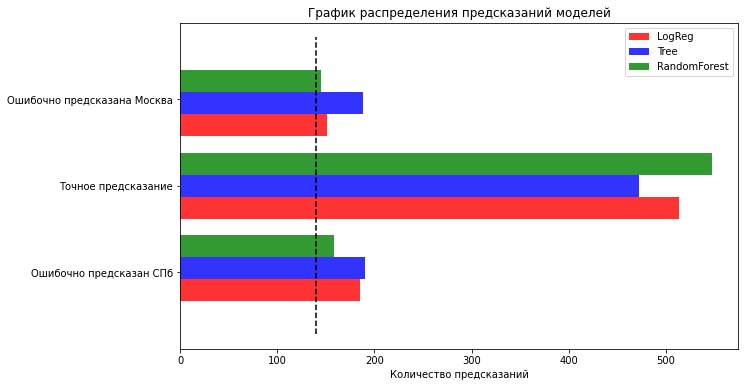

In [326]:
plt.figure(figsize=(10,6))
plt.hist([pl.LogReg, pl.Tree, pl.RandomForest], bins=3, color=['r','b','g'], alpha=0.8,
        label=['LogReg', 'Tree', 'RandomForest'], orientation='horizontal')
plt.yticks(ticks=[-0.7, 0, 0.7], labels=['Ошибочно предсказан СПб', 'Точное предсказание', 'Ошибочно предсказана Москва'])
plt.xlabel('Количество предсказаний')
plt.legend()
plt.vlines(140, -1.2, 1.2, color='k', linestyle='--')
plt.title('График распределения предсказаний моделей')
plt.show

In [327]:
# модели чаще ошибочно предсказывают СПб, чем ошибочно предсказывают Москву